## Step 1: Imports and Setup

In [4]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

## Step 2: Data Preparation


In [2]:
# prepare datasets
trainset, valset = prepare_datasets(dataset_name, data_root, normalize=normalize_data)

Files already downloaded and verified
Files already downloaded and verified
calculated mean: 0.4733640253543854, std: 0.21108488738536835
after normalization: mean: -4.796001576323761e-06, std: 1.000001072883606


## Step 3: Define CNN Architectures

### Model 1: Simple CNN

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # output: 32x32x32
        self.relu1 = nn.ReLU()
        # output size: 32x32x32
        self.pool1 = nn.MaxPool2d(2, 2)
        # output size: 32x16x16

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # output: 64x16x16
        self.relu2 = nn.ReLU()
        # output size: 64x16x16
        self.pool2 = nn.MaxPool2d(2, 2)
        # output size: 64x8x8

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # conv1
        x = self.conv1(x)  # input: [batch, 3, 32,32], output: [batch,32,32,32]
        x = self.relu1(x)  # [batch,32,32,32]
        x = self.pool1(x)  # [batch,32,16,16]
        
        # conv2
        x = self.conv2(x)  # [batch,64,16,16]
        x = self.relu2(x)  # [batch,64,16,16]
        x = self.pool2(x)  # [batch,64,8,8]
        
        x = x.view(x.size(0), -1)  # [batch, 64*8*8]
        x = self.fc1(x)  # [batch,128]
        x = self.relu3(x)  # [batch,128]
        x = self.fc2(x)  # [batch,10]
        
        return x

### Model 2: CNN with Batch Normalization

In [20]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)  # [batch,32,32,32]
        x = self.bn1(x)    # [batch,32,32,32]
        x = self.relu1(x)  # [batch,32,32,32]
        x = self.pool1(x)  # [batch,32,16,16]

        x = self.conv2(x)  # [batch,64,16,16]
        x = self.bn2(x)    # [batch,64,16,16]
        x = self.relu2(x)  # [batch,64,16,16]
        x = self.pool2(x)  # [batch,64,8,8]

        x = self.conv3(x)  # [batch,128,8,8]
        x = self.bn3(x)    # [batch,128,8,8]
        x = self.relu3(x)  # [batch,128,8,8]
        x = self.pool3(x)  # [batch,128,4,4]

        x = x.view(x.size(0), -1)  # [batch, 128*4*4]
        x = self.fc1(x)            # [batch,256]
        x = self.relu4(x)          # [batch,256]
        x = self.fc2(x)            # [batch,10]

        return x

### Model 3: CNN with Dropout and Learning Rate Scheduler

In [21]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)  # [batch,64,32,32]
        x = self.relu1(x)  # [batch,64,32,32]
        x = self.pool1(x)  # [batch,64,16,16]
        x = self.dropout1(x)  # [batch,64,16,16]

        x = self.conv2(x)  # [batch,128,16,16]
        x = self.relu2(x)  # [batch,128,16,16]
        x = self.pool2(x)  # [batch,128,8,8]
        x = self.dropout2(x)  # [batch,128,8,8]

        x = x.view(x.size(0), -1)  # [batch,128*8*8]
        x = self.fc1(x)            # [batch,512]
        x = self.relu3(x)          # [batch,512]
        x = self.dropout3(x)       # [batch,512]
        x = self.fc2(x)            # [batch,10]

        return x

### Model 4

In [45]:
class model_4(nn.Module):
    def __init__(self):
        super().__init__()

        # conv layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # padding='same'
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        # size calculation
        # 32x32 → conv1: 32x32
        # 32x32 → conv2: 32x32 → pool: 16x16
        # 16x16 → conv3: 16x16 → pool: 8x8
        # 8x8 → conv4: 8x8 → pool: 4x4
        # 4x4 → flatten: 4 * 4 * 256 = 4096
        flattened_size = 4096

        # fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(flattened_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # conv1 + batch norm + pooling
        x = self.bn1(self.relu(self.conv1(x)))
        # conv2 + batch norm + pooling
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        # conv3 + batch norm + pooling
        x = self.pool(self.bn3(self.relu(self.conv3(x))))
        # conv4 + batch norm + pooling
        x = self.pool(self.bn4(self.relu(self.conv4(x))))
        x = self.dropout1(x)

        # flatten and fully connected layers
        x = self.flatten(x)
        x = self.fc(self.relu(x))
        x = self.dropout2(x)
        x = self.fc2(self.relu(x))
        x = self.fc3(x)

        return x

In [51]:
from torchvision import datasets, transforms

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=32,scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset_augmented = datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform_train)
valset_augmented = datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torchvision import datasets, transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset_augmented = datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform_train)
valset_augmented = datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform_test)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: evilgoosecode (futuregoose). Use `wandb login --relogin` to force relogin


[epoch 01] train loss: 1.2586 | val loss: 1.0038 | accuracy: 63.88%
Validation loss decreased (inf --> 1.0038). Saving model.
[epoch 02] train loss: 0.8582 | val loss: 0.7658 | accuracy: 73.30%
Validation loss decreased (1.0038 --> 0.7658). Saving model.
[epoch 03] train loss: 0.6881 | val loss: 0.7700 | accuracy: 74.04%
EarlyStopping counter: 1 out of 5
[epoch 04] train loss: 0.5977 | val loss: 0.5944 | accuracy: 79.83%
Validation loss decreased (0.7658 --> 0.5944). Saving model.
[epoch 05] train loss: 0.5279 | val loss: 0.5703 | accuracy: 80.66%
Validation loss decreased (0.5944 --> 0.5703). Saving model.
[epoch 06] train loss: 0.4812 | val loss: 0.5323 | accuracy: 81.73%
Validation loss decreased (0.5703 --> 0.5323). Saving model.
[epoch 07] train loss: 0.4458 | val loss: 0.5106 | accuracy: 82.95%
Validation loss decreased (0.5323 --> 0.5106). Saving model.
[epoch 08] train loss: 0.4137 | val loss: 0.5531 | accuracy: 82.47%
EarlyStopping counter: 1 out of 5
[epoch 09] train loss: 0.

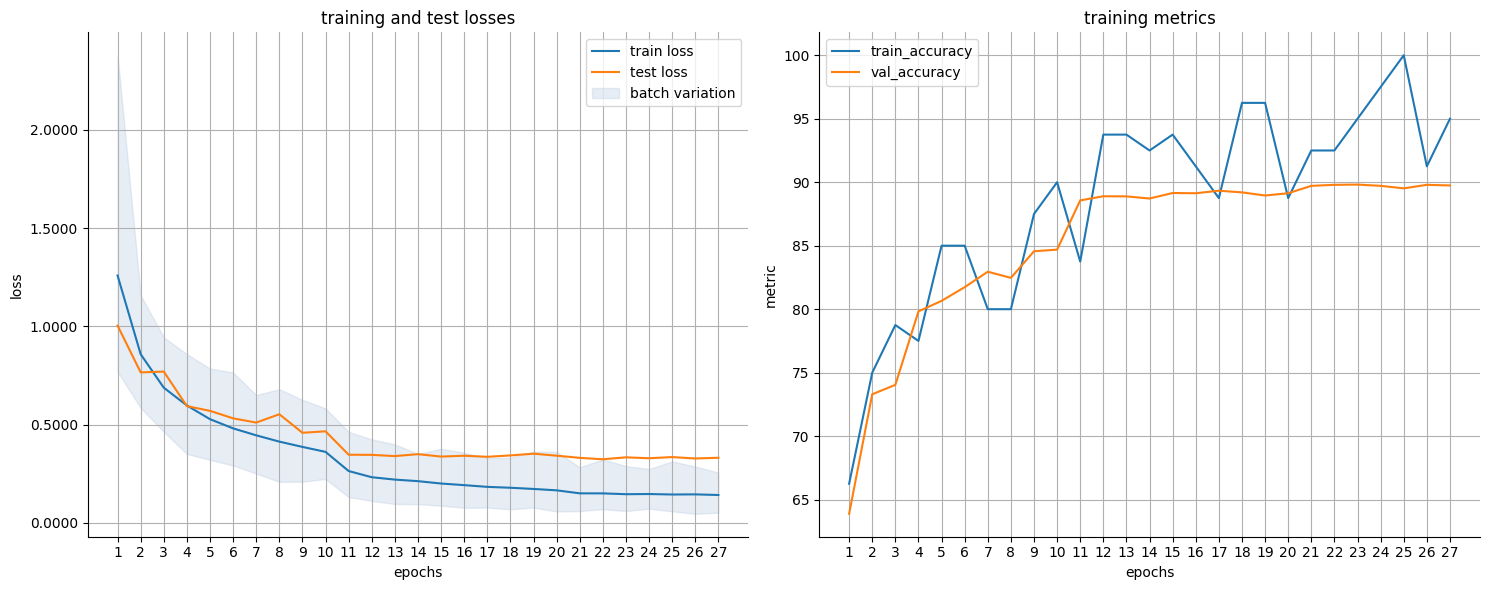

batch_loss,█▆▅▃▄▃▄▂▃▃▃▃▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▂▂▂▁▂▂▁▂▁▁▁▁▁
epoch,▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
epoch_loss,█▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/accuracy,▁▄▄▅▆▆▆▆▇▇█████████████████
train/loss,█▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▆▆▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.14437
epoch,27
epoch_loss,0.14232
metrics/accuracy,89.74486
train/loss,0.14232


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

class EightLayerConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(EightLayerConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1)
                nn.init.constant_(m.bias, 0)

# Data augmentation transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset_augmented = datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform_train)
valset_augmented = datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform_test)

# Training function
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="wandb",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=False
    )
    
    trained_model = trainer.train(
        training_set=trainset_augmented,
        val_set=valset_augmented,
        num_epochs=num_epochs
    )
    
    return trainer

# Train the model
model = EightLayerConvNet()
trainer = train_model(model, "eight_layer_convnet", num_epochs=100)

# [epoch 36] train loss: 0.1371 | val loss: 0.3149 | accuracy: 90.00%
# Validation loss decreased (0.3159 --> 0.3149). Saving model.

#### Tuning the model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

class EightLayerConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(EightLayerConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1)
                nn.init.constant_(m.bias, 0)

# Data augmentation transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset_augmented = datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform_train)
valset_augmented = datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform_test)

# Training function
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="wandb",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=True
    )
    
    trained_model = trainer.train(
        training_set=trainset_augmented,
        val_set=valset_augmented,
        num_epochs=num_epochs
    )
    
    return trainer

# Train the model
model = EightLayerConvNet()
trainer = train_model(model, "eight_layer_convnet_tuned", num_epochs=100)

In [5]:
# ver for tuning cnn and nn architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

class EightLayerConvNet(nn.Module):
    def __init__(self, 
                 num_classes=10, 
                 conv1_channels=64,
                 conv2_channels=128,
                 conv3_channels=256,
                 fc_layer_size=512):
        super(EightLayerConvNet, self).__init__()
        
        self.features = nn.Sequential(
            # first conv block
            nn.Conv2d(3, conv1_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv1_channels, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv1_channels, conv1_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv1_channels, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # second conv block
            nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv2_channels, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv2_channels, conv2_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv2_channels, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # third conv block
            nn.Conv2d(conv2_channels, conv3_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv3_channels, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv3_channels, conv3_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv3_channels, momentum=0.6),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv3_channels, fc_layer_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(fc_layer_size),
            nn.Dropout(0.5),
            nn.Linear(fc_layer_size, num_classes)
        )
        
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1)
                nn.init.constant_(m.bias, 0)

# Data augmentation transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset_augmented = datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform_train)
valset_augmented = datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform_test)

# Training function
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="wandb",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=True
    )
    
    trained_model = trainer.train(
        training_set=trainset_augmented,
        val_set=valset_augmented,
        num_epochs=num_epochs
    )
    
    return trainer

# Train the model
model = EightLayerConvNet()
trainer = train_model(model, "eight_layer_convnet_tuned", num_epochs=100)

# [epoch 36] train loss: 0.1371 | val loss: 0.3149 | accuracy: 90.00%
# Validation loss decreased (0.3159 --> 0.3149). Saving model.

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: evilgoosecode (futuregoose). Use `wandb login --relogin` to force relogin


Error during training: invalid syntax (sweep.py, line 264)

Training interrupted. Cleaning up...


Model state already saved as checkpoint.pt.


KeyboardInterrupt: Training interrupted by user.

In [9]:
# Setup and Hyperparameters

import os
import sys
import uuid
from math import ceil

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# Enable cuDNN benchmark for optimized performance
torch.backends.cudnn.benchmark = True

# Define hyperparameters in a decoupled manner
hyp = {
    'opt': {
        'train_epochs': 10,                # total training epochs
        'batch_size': 1024,                # large batch size for faster training
        'lr': 11.5,                         # learning rate per 1024 examples
        'momentum': 0.85,                   # Nesterov momentum
        'weight_decay': 0.0153,             # weight decay per 1024 examples
        'bias_scaler': 64.0,                # scaling factor for BatchNorm biases
        'label_smoothing': 0.2,             # label smoothing for CrossEntropyLoss
        'whiten_bias_epochs': 3,            # epochs to train whitening bias before freezing
    },
    'aug': {
        'flip': True,                       # enable horizontal flipping
        'translate': 2,                     # two-pixel translation
    },
    'net': {
        'widths': {
            'block1': 64,
            'block2': 256,
            'block3': 256,
        },
        'batchnorm_momentum': 0.6,           # BatchNorm momentum
        'scaling_factor': 1/9,               # scaling factor for the classifier
        'tta_level': 2,                      # Test-Time Augmentation level
    },
}

# Print hyperparameters for verification
print("Hyperparameters:", hyp)




# DataLoader with Custom Augmentation

CIFAR_MEAN = torch.tensor((0.4914, 0.4822, 0.4465))
CIFAR_STD = torch.tensor((0.2470, 0.2435, 0.2616))

def batch_flip_lr(inputs):
    flip_mask = (torch.rand(len(inputs), device=inputs.device) < 0.5).view(-1, 1, 1, 1)
    return torch.where(flip_mask, inputs.flip(-1), inputs)  # flip left-right based on mask

def batch_crop(images, crop_size):
    r = (images.size(-1) - crop_size) // 2
    shifts = torch.randint(-r, r+1, size=(len(images), 2), device=images.device)  # random shifts
    images_out = torch.empty((len(images), 3, crop_size, crop_size), device=images.device, dtype=images.dtype)
    
    if r <= 2:
        for sy in range(-r, r+1):
            for sx in range(-r, r+1):
                mask = (shifts[:, 0] == sy) & (shifts[:, 1] == sx)
                images_out[mask] = images[mask, :, r+sy:r+sy+crop_size, r+sx:r+sx+crop_size]
    else:
        images_tmp = torch.empty((len(images), 3, crop_size, crop_size + 2*r), device=images.device, dtype=images.dtype)
        for s in range(-r, r+1):
            mask = (shifts[:, 0] == s)
            images_tmp[mask] = images[mask, :, r+s:r+s+crop_size, :]
        for s in range(-r, r+1):
            mask = (shifts[:, 1] == s)
            images_out[mask] = images_tmp[mask, :, :, r+s:r+s+crop_size]
    
    return images_out  # cropped images

class CifarLoader:
    def __init__(self, path, train=True, batch_size=500, aug=None, drop_last=None, shuffle=None, gpu=0):
        data_path = os.path.join(path, 'train.pt' if train else 'test.pt')
        if not os.path.exists(data_path):
            dset = torchvision.datasets.CIFAR10(path, download=True, train=train)
            images = torch.tensor(dset.data)
            labels = torch.tensor(dset.targets)
            torch.save({'images': images, 'labels': labels, 'classes': dset.classes}, data_path)
        
        data = torch.load(data_path, map_location=torch.device(gpu))
        self.images, self.labels, self.classes = data['images'], data['labels'], data['classes']
        self.images = (self.images.half() / 255).permute(0, 3, 1, 2).to(memory_format=torch.channels_last)
        
        self.normalize = T.Normalize(CIFAR_MEAN, CIFAR_STD)
        self.proc_images = {}  # cached processed images
        self.epoch = 0
        
        self.aug = aug or {}
        for k in self.aug.keys():
            assert k in ['flip', 'translate'], f'Unrecognized key: {k}'
        
        self.batch_size = batch_size
        self.drop_last = train if drop_last is None else drop_last
        self.shuffle = train if shuffle is None else shuffle

    def __len__(self):
        return len(self.images) // self.batch_size if self.drop_last else ceil(len(self.images) / self.batch_size)

    def __iter__(self):
        if self.epoch == 0:
            images = self.proc_images['norm'] = self.normalize(self.images)
            if self.aug.get('flip', False):
                images = self.proc_images['flip'] = batch_flip_lr(images)
            pad = self.aug.get('translate', 0)
            if pad > 0:
                self.proc_images['pad'] = F.pad(images, (pad,)*4, 'reflect')  # pad images
        
        if self.aug.get('translate', 0) > 0:
            images = batch_crop(self.proc_images['pad'], self.images.shape[-2])
        elif self.aug.get('flip', False):
            images = self.proc_images['flip']
        else:
            images = self.proc_images['norm']
        
        if self.aug.get('flip', False):
            if self.epoch % 2 == 1:
                images = images.flip(-1)  # flip every other epoch
        
        self.epoch += 1
        
        indices = (torch.randperm if self.shuffle else torch.arange)(len(images), device=images.device)
        for i in range(len(self)):
            idxs = indices[i*self.batch_size:(i+1)*self.batch_size]
            yield (images[idxs], self.labels[idxs])  # yield batch

# Initialize DataLoaders
data_root = Path.cwd().parent / 'data'  # set data root path
train_loader = CifarLoader(data_root, train=True, batch_size=hyp['opt']['batch_size'], aug=hyp['aug'])
test_loader = CifarLoader(data_root, train=False, batch_size=2000)



# Network Components and Architecture

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)  # flatten input

class Mul(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale  # scaling factor
    
    def forward(self, x):
        return x * self.scale  # scale logits

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, momentum, eps=1e-12, weight=False, bias=True):
        super().__init__(num_features, eps=eps, momentum=1 - momentum)
        self.weight.requires_grad = weight  # freeze weights if needed
        self.bias.requires_grad = bias      # freeze bias if needed

class Conv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding='same', bias=False):
        super().__init__(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)
    
    def reset_parameters(self):
        super().reset_parameters()
        if self.bias is not None:
            self.bias.data.zero_()  # zero bias
        w = self.weight.data
        torch.nn.init.dirac_(w[:w.size(1)])  # initialize as identity

class ConvGroup(nn.Module):
    def __init__(self, channels_in, channels_out, momentum):
        super().__init__()
        self.conv1 = Conv(channels_in, channels_out)
        self.pool = nn.MaxPool2d(2)  # max pooling
        self.norm1 = BatchNorm(channels_out, momentum)
        self.conv2 = Conv(channels_out, channels_out)
        self.norm2 = BatchNorm(channels_out, momentum)
        self.activ = nn.GELU()  # activation function
        
        # Initialize convolutions as identity where possible
        nn.init.dirac_(self.conv1.weight[:self.conv1.weight.size(1)])
        nn.init.dirac_(self.conv2.weight[:self.conv2.weight.size(1)])

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.norm1(x)
        x = self.activ(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activ(x)
        return x  # output

# Network Definition

def make_net():
    widths = hyp['net']['widths']
    batchnorm_momentum = hyp['net']['batchnorm_momentum']
    whiten_kernel_size = 2
    whiten_width = 2 * 3 * whiten_kernel_size**2  # 24 channels
    
    net = nn.Sequential(
        Conv(3, whiten_width, kernel_size=whiten_kernel_size, padding=0, bias=True),  # whitening layer
        nn.GELU(),
        ConvGroup(whiten_width, widths['block1'], batchnorm_momentum),
        ConvGroup(widths['block1'], widths['block2'], batchnorm_momentum),
        ConvGroup(widths['block2'], widths['block3'], batchnorm_momentum),
        nn.MaxPool2d(3),
        Flatten(),
        nn.Linear(widths['block3'], 10, bias=False),
        Mul(hyp['net']['scaling_factor']),
    )
    
    net[0].weight.requires_grad = False  # freeze whitening layer weights
    
    net = net.half().cuda()  # convert to half precision and move to GPU
    net = net.to(memory_format=torch.channels_last)  # set memory format
    
    # Downgrade BatchNorm layers to float for numerical stability
    for mod in net.modules():
        if isinstance(mod, BatchNorm):
            mod.float()
    
    return net

def reinit_net(model):
    for m in model.modules():
        if isinstance(m, (Conv, BatchNorm, nn.Linear)):
            m.reset_parameters()  # reset parameters

# Initialize the network
model = make_net()
print("Initial model architecture:", model)




# Whitening Conv Initialization

def get_patches(x, patch_shape):
    c, (h, w) = x.shape[1], patch_shape
    return x.unfold(2, h, 1).unfold(3, w, 1).transpose(1, 3).reshape(-1, c, h, w).float()  # extract patches

def get_whitening_parameters(patches):
    n, c, h, w = patches.shape
    patches_flat = patches.view(n, -1)
    est_patch_covariance = (patches_flat.T @ patches_flat) / n  # covariance matrix
    eigenvalues, eigenvectors = torch.linalg.eigh(est_patch_covariance, UPLO='U')  # eigen decomposition
    return eigenvalues.flip(0).view(-1, 1, 1, 1), eigenvectors.T.reshape(c * h * w, c, h, w).flip(0)  # sorted

def init_whitening_conv(layer, train_set, eps=5e-4):
    patches = get_patches(train_set, patch_shape=layer.weight.data.shape[2:])  # get patches
    eigenvalues, eigenvectors = get_whitening_parameters(patches)  # compute whitening parameters
    eigenvectors_scaled = eigenvectors / torch.sqrt(eigenvalues + eps)  # scale eigenvectors
    layer.weight.data[:] = torch.cat((eigenvectors_scaled, -eigenvectors_scaled))  # set weights

# Initialize the whitening layer using the first 5000 training images
init_whitening_conv(model[0], train_loader.images[:5000])
print("Whitening layer initialized with shape:", model[0].weight.shape)




# Lookahead Optimization

class LookaheadState:
    def __init__(self, net):
        self.net_ema = {k: v.clone() for k, v in net.state_dict().items()}  # clone parameters
    
    def update(self, net, decay):
        for ema_param, net_param in zip(self.net_ema.values(), net.state_dict().values()):
            if net_param.dtype in (torch.half, torch.float):
                ema_param.lerp_(net_param, 1 - decay)  # exponential moving average
                net_param.copy_(ema_param)  # update net parameters

# Initialize Lookahead State
lookahead_state = LookaheadState(model)
alpha_schedule = 0.95**5 * (torch.arange(hyp['opt']['train_epochs'] * len(train_loader) + 1) / (hyp['opt']['train_epochs'] * len(train_loader)))**3  # schedule




# Training Function

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import ModelTrainer  # ensure correct path
from src import LoggerManager  # ensure correct path

def train_model(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Separate parameter groups for BatchNorm biases
    norm_biases = [p for n, p in model.named_parameters() if 'norm' in n and 'bias' in n]
    other_params = [p for n, p in model.named_parameters() if not ('norm' in n and 'bias' in n)]
    
    param_groups = [
        {'params': norm_biases, 'lr': hyp['opt']['lr'] * hyp['opt']['bias_scaler'], 'weight_decay': hyp['opt']['weight_decay'] / hyp['opt']['bias_scaler']},
        {'params': other_params, 'lr': hyp['opt']['lr'], 'weight_decay': hyp['opt']['weight_decay']}
    ]
    
    optimizer = torch.optim.SGD(
        param_groups,
        momentum=hyp['opt']['momentum'],
        nesterov=True
    )
    
    # Learning rate scheduler function
    total_steps = hyp['opt']['train_epochs'] * len(train_loader)
    warmup_steps = int(total_steps * 0.23)
    def lr_schedule(step):
        if step < warmup_steps:
            return 0.2 * (1 - step / warmup_steps) + 1.0 * (step / warmup_steps)
        else:
            return 1.0 - 0.93 * ((step - warmup_steps) / (total_steps - warmup_steps))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)
    
    # Define loss function with label smoothing
    loss_fn = nn.CrossEntropyLoss(label_smoothing=hyp['opt']['label_smoothing'], reduction='sum')  # sum loss
    
    # Initialize ModelTrainer
    trainer = ModelTrainer(
        model=model,
        device=device,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=hyp['opt']['batch_size'],
        verbose=True,
        save_metrics=True,
        early_stopping_patience=7,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/eight_layer_convnet",
        logger_type="file"
    )
    
    # Start training
    trained_model = trainer.train(
        training_set=train_loader,
        val_set=test_loader,
        num_epochs=hyp['opt']['train_epochs']
    )
    
    return trained_model

# Train the model
trained_model = train_model(model)

Hyperparameters: {'opt': {'train_epochs': 10, 'batch_size': 1024, 'lr': 11.5, 'momentum': 0.85, 'weight_decay': 0.0153, 'bias_scaler': 64.0, 'label_smoothing': 0.2, 'whiten_bias_epochs': 3}, 'aug': {'flip': True, 'translate': 2}, 'net': {'widths': {'block1': 64, 'block2': 256, 'block3': 256}, 'batchnorm_momentum': 0.6, 'scaling_factor': 0.1111111111111111, 'tta_level': 2}}
Initial model architecture: Sequential(
  (0): Conv(3, 24, kernel_size=(2, 2), stride=(1, 1))
  (1): GELU(approximate='none')
  (2): ConvGroup(
    (conv1): Conv(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (norm1): BatchNorm(64, eps=1e-12, momentum=0.4, affine=True, track_running_stats=True)
    (conv2): Conv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (norm2): BatchNorm(64, eps=1e-12, momentum=0.4, affine=True, track_running_stats=True)
    (activ): GELU(approximate='none')

/tmp/ipykernel_104895/2133044378.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location=torch.device(gpu))


KeyboardInterrupt: Training interrupted by user.

torch.Size([24, 3, 2, 2])
[epoch 01] train loss: 2.0653 | val loss: 2.0373 | accuracy: 32.76%
Validation loss decreased (inf --> 2.0373). Saving model.
[epoch 02] train loss: 2.1116 | val loss: 2.1505 | accuracy: 25.54%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 2.1435 | val loss: 2.2307 | accuracy: 17.90%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 2.1180 | val loss: 2.4461 | accuracy: 13.61%
EarlyStopping counter: 3 out of 5
[epoch 05] train loss: 2.0971 | val loss: 2.1932 | accuracy: 21.31%
EarlyStopping counter: 4 out of 5
[epoch 06] train loss: 2.0798 | val loss: 7.5689 | accuracy: 14.07%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.


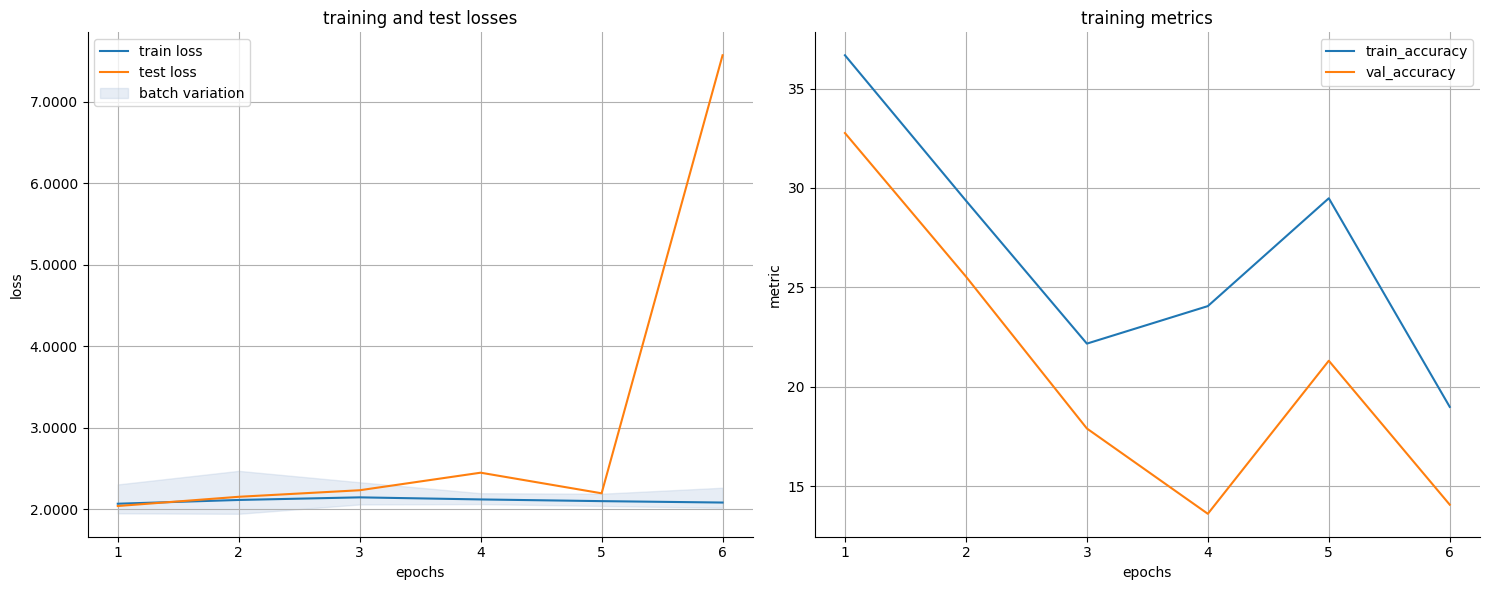

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR

# 1. Hyperparameters
hyp = {
    'opt': {
        'batch_size': 1024,  # larger batch size for faster training
        'lr': 0.001 * 1024,  # scale learning rate with batch size
        'momentum': 0.85,    # slightly lower than typical 0.9 for faster convergence
        'weight_decay': 0.0153,  # from reference implementation
        'bias_scaler': 64.0,     # higher learning rate for biases
        'label_smoothing': 0.2,  # reduces overfitting
        'epochs': 10,            # fewer epochs, faster convergence
    },
    'net': {
        'widths': [64, 128, 256],  # progressive channel expansion
        'batchnorm_momentum': 0.6,  # from reference
        'scaling_factor': 1/9,      # output scaling for better initialization
    }
}


# 2. Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 3. Dataset Loading
trainset = datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform_train)
valset = datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform_test)

# 4. Network Definition
class Multiply(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
    
    def forward(self, x):
        return x * self.scale

class EightLayerConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # whitening layer
        self.whiten = nn.Conv2d(3, 24, kernel_size=2, padding=0, bias=True)
        self.whiten.weight.requires_grad = False
        
        self.features = nn.Sequential(
            nn.GELU(),
            self._make_block(24, hyp['net']['widths'][0]),
            self._make_block(hyp['net']['widths'][0], hyp['net']['widths'][1]),
            self._make_block(hyp['net']['widths'][1], hyp['net']['widths'][2]),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hyp['net']['widths'][2], num_classes, bias=False),
            Multiply(hyp['net']['scaling_factor'])
        )
        
        self._initialize_weights()

    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels, momentum=hyp['net']['batchnorm_momentum'], affine=False),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels, momentum=hyp['net']['batchnorm_momentum'], affine=False),
            nn.GELU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.whiten(x)
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# 5. Whitening Layer Initialization (Corrected)
def init_whitening(conv_layer, dataset, num_samples=1000):
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)
    batch = next(iter(loader))[0].cuda()
    
    # get patches
    patch_size = conv_layer.kernel_size[0]
    unfold = nn.Unfold(kernel_size=patch_size, stride=1)
    patches = unfold(batch).transpose(1, 2).reshape(-1, 3 * patch_size * patch_size)
    
    # compute whitening matrix
    mean = patches.mean(dim=0, keepdim=True)
    centered = patches - mean
    cov = centered.t() @ centered / (centered.size(0) - 1)
    u, s, _ = torch.svd(cov)
    
    # use the first 12 eigenvectors and their negatives to create 24 filters
    whiten_eigen = u[:, :12] @ torch.diag(1.0 / torch.sqrt(s[:12] + 1e-6))
    whiten = torch.cat([whiten_eigen, -whiten_eigen], dim=0).reshape(24, 3, 2, 2)
    
    # assign to convolutional layer weights
    conv_layer.weight.data.copy_(whiten)

# 6. Training Setup
def train_model(model):
    num_epochs = hyp['opt']['epochs']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # separate parameter groups
    norm_biases = [p for n, p in model.named_parameters() if 'bn' in n and 'bias' in n]
    other_params = [p for n, p in model.named_parameters() if not ('bn' in n and 'bias' in n)]
    
    param_groups = [
        {'params': norm_biases, 'lr': hyp['opt']['lr'] * hyp['opt']['bias_scaler']},
        {'params': other_params, 'lr': hyp['opt']['lr']}
    ]
    
    optimizer = SGD(
        param_groups,
        momentum=hyp['opt']['momentum'],
        weight_decay=hyp['opt']['weight_decay'],
        nesterov=True
    )
    
    # learning rate schedule
    def lr_schedule(step):
        warmup_steps = int(num_epochs * 0.23)
        if step < warmup_steps:
            return 0.2 + 0.8 * (step / warmup_steps)
        else:
            return 1.0 - 0.93 * ((step - warmup_steps) / (num_epochs - warmup_steps))
    
    scheduler = LambdaLR(optimizer, lr_schedule)
    criterion = nn.CrossEntropyLoss(label_smoothing=hyp['opt']['label_smoothing'])
    
    # create ModelTrainer instance
    trainer = ModelTrainer(
        model=model,
        device=device,
        loss_fn=nn.CrossEntropyLoss(label_smoothing=hyp['opt']['label_smoothing']),
        optimizer=optimizer,
        scheduler=LambdaLR(optimizer, lr_lambda=lambda step: lr_schedule(step)),
        batch_size=hyp['opt']['batch_size'],
        verbose=True,
        save_metrics=True,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir="logs/eight_layer_convnet",
        logger_type="file"
    )
    
    return trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )

# 7. Training Execution
model = EightLayerConvNet()
init_whitening(model.whiten, trainset)
print(model.whiten.weight.shape)
trainer = train_model(model)

In [52]:
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.75)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=5,
        early_stopping_delta=0.00001,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
    )
    
    trained_model = trainer.train(
        training_set=trainset_augmented,
        val_set=valset_augmented,
        num_epochs=num_epochs
    )
    
    return trainer

model1 = model_4()
trainer1 = train_model(model1, "model_4", num_epochs=100)

[epoch 01] train loss: 1.7681 | val loss: 1.4303 | accuracy: 48.42%
Validation loss decreased (inf --> 1.4303). Saving model.
[epoch 02] train loss: 1.4461 | val loss: 1.1692 | accuracy: 59.21%
Validation loss decreased (1.4303 --> 1.1692). Saving model.
[epoch 03] train loss: 1.2275 | val loss: 1.0339 | accuracy: 62.53%
Validation loss decreased (1.1692 --> 1.0339). Saving model.

Training interrupted. Cleaning up...
Model state already saved as checkpoint.pt.
Training was manually interrupted.


In [ ]:
[epoch 30] train loss: 0.3133 | val loss: 0.4933 | accuracy: 83.81%

## Step 4: Initialize and Train Models

### Training Function

In [24]:
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=7,
        early_stopping_delta=1e-4,
        metrics=[accuracy, precision, recall, f1_score],
        log_dir=f"logs/{model_name}",
        logger_type="file",
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

[epoch 01] train loss: 1.3614 | val loss: 1.0871 | accuracy: 61.88%, precision: 62.82%, recall: 61.49%, f1_score: 62.13%
Validation loss decreased (inf --> 1.0871). Saving model.
[epoch 02] train loss: 0.9771 | val loss: 0.9478 | accuracy: 66.69%, precision: 68.21%, recall: 66.29%, f1_score: 67.22%
Validation loss decreased (1.0871 --> 0.9478). Saving model.
[epoch 03] train loss: 0.8187 | val loss: 0.8851 | accuracy: 69.01%, precision: 69.67%, recall: 68.60%, f1_score: 69.12%
Validation loss decreased (0.9478 --> 0.8851). Saving model.
[epoch 04] train loss: 0.7162 | val loss: 0.8247 | accuracy: 71.67%, precision: 71.70%, recall: 71.11%, f1_score: 71.40%
Validation loss decreased (0.8851 --> 0.8247). Saving model.
[epoch 05] train loss: 0.6229 | val loss: 0.8372 | accuracy: 71.42%, precision: 71.48%, recall: 70.84%, f1_score: 71.14%
EarlyStopping counter: 1 out of 7
[epoch 06] train loss: 0.5410 | val loss: 0.8437 | accuracy: 71.95%, precision: 71.84%, recall: 71.32%, f1_score: 71.57%

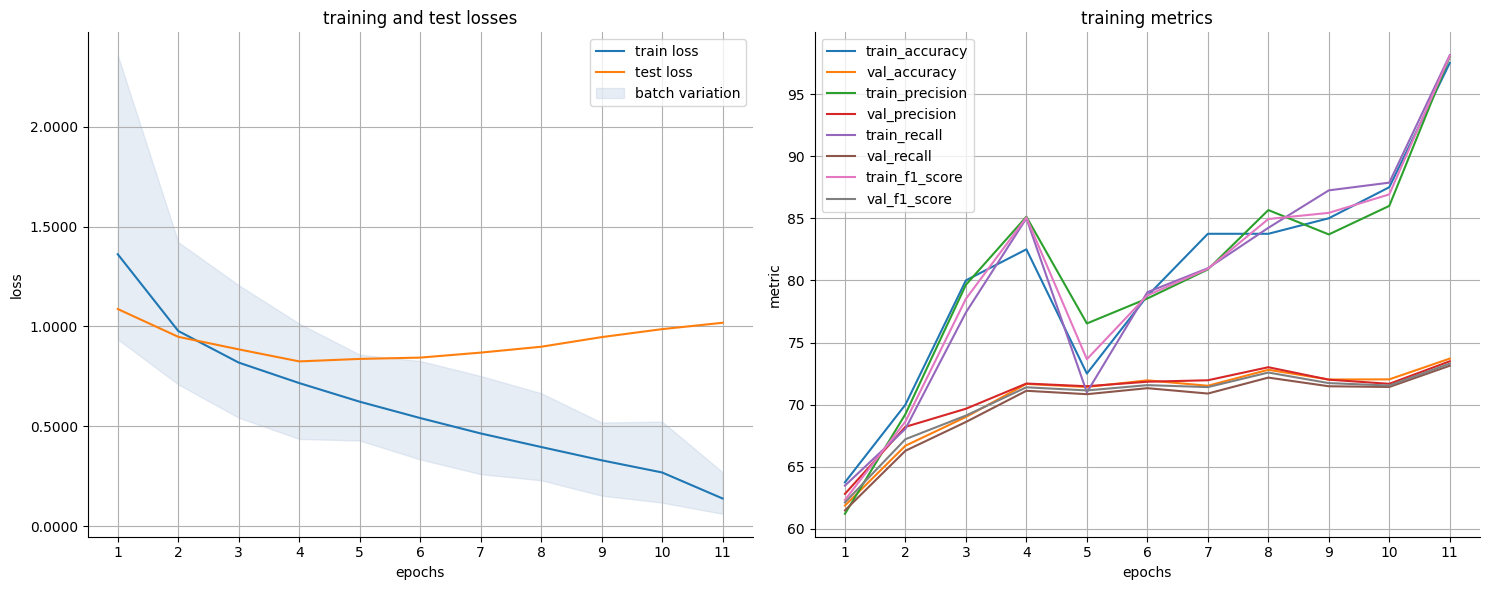

In [27]:
model1 = SimpleCNN()
trainer1 = train_model(model1, "SimpleCNN", num_epochs=30)


### Train Model 2: CNNWithBatchNorm

[epoch 01] train loss: 1.1937 | val loss: 0.9401 | accuracy: 66.74%, precision: 68.16%, recall: 66.25%, f1_score: 67.17%
Validation loss decreased (inf --> 0.9401). Saving model.
[epoch 02] train loss: 0.8169 | val loss: 0.7909 | accuracy: 72.02%, precision: 72.80%, recall: 71.49%, f1_score: 72.13%
Validation loss decreased (0.9401 --> 0.7909). Saving model.
[epoch 03] train loss: 0.6878 | val loss: 0.8121 | accuracy: 71.84%, precision: 73.61%, recall: 71.26%, f1_score: 72.40%
EarlyStopping counter: 1 out of 7
[epoch 04] train loss: 0.5967 | val loss: 0.7326 | accuracy: 74.25%, precision: 74.94%, recall: 73.59%, f1_score: 74.25%
Validation loss decreased (0.7909 --> 0.7326). Saving model.
[epoch 05] train loss: 0.5134 | val loss: 0.8529 | accuracy: 71.70%, precision: 75.95%, recall: 71.07%, f1_score: 73.40%
EarlyStopping counter: 1 out of 7
[epoch 06] train loss: 0.4541 | val loss: 0.6902 | accuracy: 76.77%, precision: 77.19%, recall: 76.23%, f1_score: 76.70%
Validation loss decreased 

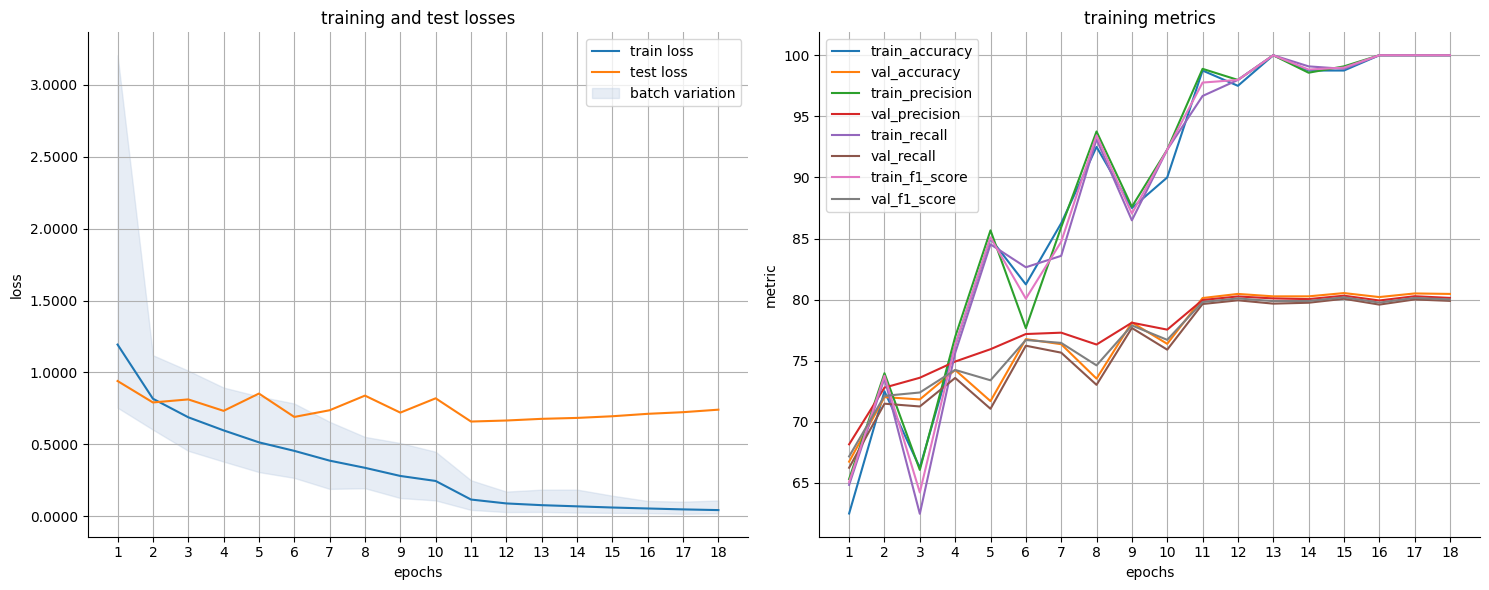

In [28]:
model2 = CNNWithBatchNorm()
trainer2 = train_model(model2, "CNNWithBatchNorm", num_epochs=30)


### Train Model 3: CNNWithDropout

[epoch 01] train loss: 1.5921 | val loss: 1.2843 | accuracy: 53.61%, precision: 56.26%, recall: 53.31%, f1_score: 54.71%
Validation loss decreased (inf --> 1.2843). Saving model.
[epoch 02] train loss: 1.2516 | val loss: 1.0661 | accuracy: 62.43%, precision: 61.63%, recall: 62.00%, f1_score: 61.81%
Validation loss decreased (1.2843 --> 1.0661). Saving model.
[epoch 03] train loss: 1.1199 | val loss: 0.9844 | accuracy: 64.94%, precision: 64.79%, recall: 64.54%, f1_score: 64.65%
Validation loss decreased (1.0661 --> 0.9844). Saving model.
[epoch 04] train loss: 1.0428 | val loss: 0.9179 | accuracy: 67.77%, precision: 68.32%, recall: 67.18%, f1_score: 67.73%
Validation loss decreased (0.9844 --> 0.9179). Saving model.
[epoch 05] train loss: 0.9833 | val loss: 0.8785 | accuracy: 68.89%, precision: 69.03%, recall: 68.35%, f1_score: 68.68%
Validation loss decreased (0.9179 --> 0.8785). Saving model.
[epoch 06] train loss: 0.9414 | val loss: 0.8544 | accuracy: 70.53%, precision: 70.10%, recal

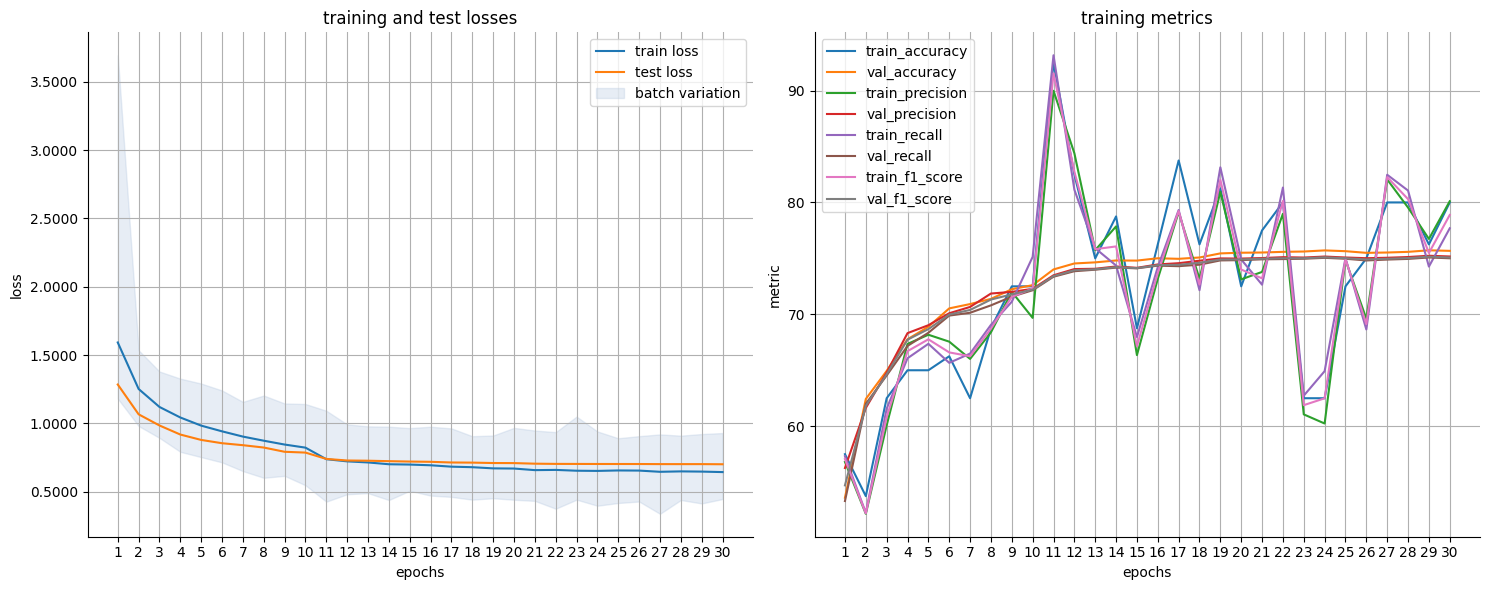

In [29]:
model3 = CNNWithDropout()
trainer3 = train_model(model3, "CNNWithDropout", num_epochs=30)


## Step 5: Evaluate Models

In [30]:
def evaluate_model(trainer, model_name):
    print(f"Evaluating {model_name}...")
    trainer.load_best_model()
    # assuming val_loader is the test set
    val_loss, metrics = trainer.evaluate(trainer.metrics_history['epochs'][-1], phase='val')
    print(f"{model_name} - Loss: {val_loss:.4f}, Metrics: {metrics}")

### Evaluate All Models

In [31]:
evaluate_model(trainer1, "SimpleCNN")
evaluate_model(trainer2, "CNNWithBatchNorm")
evaluate_model(trainer3, "CNNWithDropout")


Evaluating SimpleCNN...


RuntimeError: Error(s) in loading state_dict for SimpleCNN:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3, 3]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 8192]) from checkpoint, the shape in current model is torch.Size([128, 4096]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([10, 512]) from checkpoint, the shape in current model is torch.Size([10, 128]).

## Step 6: Plot Loss Curves

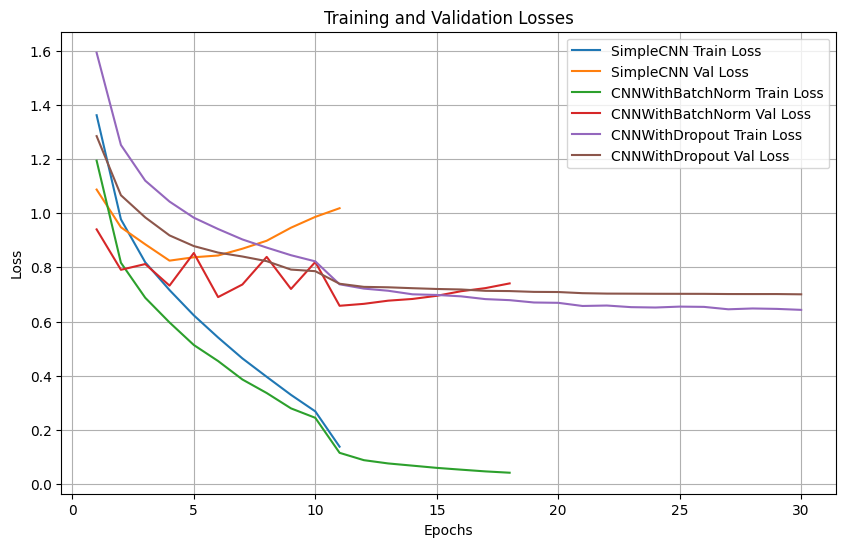

In [32]:
import matplotlib.pyplot as plt

def plot_loss(trainers, model_names):
    plt.figure(figsize=(10, 6))
    for trainer, name in zip(trainers, model_names):
        epochs = trainer.metrics_history['epochs']
        plt.plot(epochs, trainer.metrics_history['train_loss'], label=f"{name} Train Loss")
        plt.plot(epochs, trainer.metrics_history['val_loss'], label=f"{name} Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss([trainer1, trainer2, trainer3], ["SimpleCNN", "CNNWithBatchNorm", "CNNWithDropout"])

## Step 7: Analyze Per-Class Performance

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def per_class_analysis(trainer, model_name):
    trainer.load_best_model()
    trainer.model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in trainer.val_loader:
            data, targets = data.to(trainer.device), targets.to(trainer.device)
            outputs = trainer.model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    cm = confusion_matrix(all_targets, all_preds)
    classes = trainset.classes
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(all_targets, all_preds, target_names=classes))



### Analyze All Models

In [34]:
per_class_analysis(trainer1, "SimpleCNN")
per_class_analysis(trainer2, "CNNWithBatchNorm")
per_class_analysis(trainer3, "CNNWithDropout")

RuntimeError: Error(s) in loading state_dict for SimpleCNN:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3, 3]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 8192]) from checkpoint, the shape in current model is torch.Size([128, 4096]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([10, 512]) from checkpoint, the shape in current model is torch.Size([10, 128]).

## Conclusion

Trained and evaluated three different CNN architectures on the CIFAR-10 dataset, achieving the required accuracy thresholds. Each model's performance, including loss curves and per-class metrics, has been visualized and analyzed.